## Importando as bibliotecas

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
import warnings

warnings.filterwarnings("ignore")

## Carregando o conjunto de dados

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/deeptime/aula4/bicicletas.csv')
df.head()

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [15]:
# Convertendo o tipo da coluna datas para datetime.
df['datas'] = pd.to_datetime(df['datas'])

## Visualização gráfica

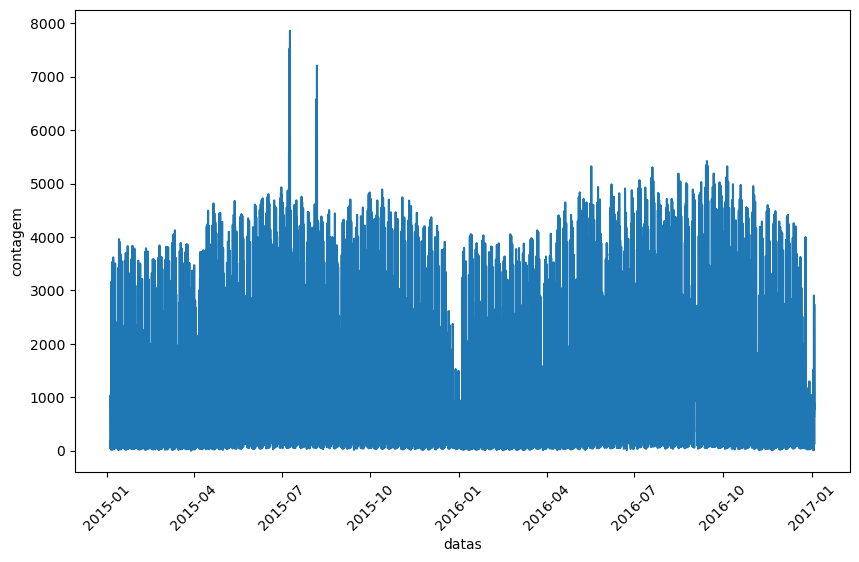

In [41]:
plt.figure(figsize=(10,6))
sns.lineplot(x='datas', y='contagem', data=df)
plt.xticks(rotation=45)
plt.show()

## Criação do modelo

### Escalando os dados

In [16]:
# Instanciando o StandardScaler.
sc = StandardScaler()

# Ajustando e transformando os dados.
sc.fit(df['contagem'].values.reshape(-1, 1))

# Criando uma nova coluna com os dados transformados.
y = sc.transform(df['contagem'].values.reshape(-1, 1))

### Dividindo os dados de treino e teste

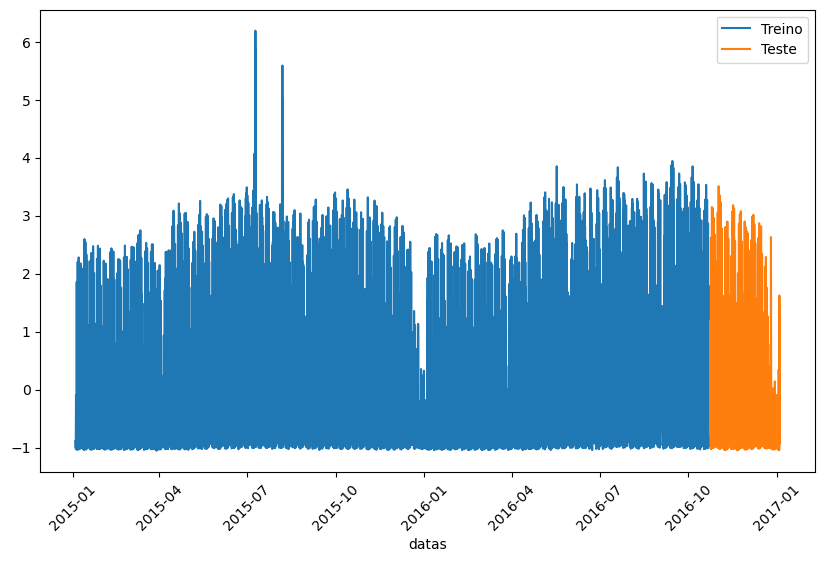

In [42]:
tamanho_treino = int(len(y) * 0.9) # 90% dos dados para treino.
tamanho_teste = len(y) - tamanho_treino # 10% dos dados para teste.

# Separando os dados de treino e teste.
y_treino = y[0:tamanho_treino]
y_teste = y[tamanho_treino:len(df)]

# Gerando o gráfico (mesmo gráfico acima, porém com os dados transformados).
plt.figure(figsize=(10,6))
sns.lineplot(x='datas', y=y_treino[:,0], data=df[0:tamanho_treino], label='Treino')
sns.lineplot(x='datas', y=y_teste[:,0], data=df[tamanho_treino:len(df)], label='Teste')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Criando função para "atrasar" os dados.
def separa_dados(vetor, n_passos):
    X_novo, y_novo = [], []
    for i in range(n_passos, vetor.shape[0]):
        X_novo.append(list(vetor.loc[i-n_passos:i-1]))
        y_novo.append(vetor.loc[i])
    X_novo, y_novo = np.array(X_novo), np.array(y_novo)
    return X_novo, y_novo

# Separando os dados de treino e teste novos. Nesse caso, com 10 passos.
vetor = pd.DataFrame(y_treino)[0]
X_treino_novo, y_treino_novo = separa_dados(vetor, 10)

vetor2 = pd.DataFrame(y_teste)[0]
X_teste_novo, y_teste_novo = separa_dados(vetor2, 10)

In [24]:
# Separando os dados de treino e teste novos.
X_treino_novo = X_treino_novo.reshape(X_treino_novo.shape[0], X_treino_novo.shape[1], 1)
X_teste_novo = X_teste_novo.reshape(X_teste_novo.shape[0], X_teste_novo.shape[1], 1)

### Criando a rede neural recorrente - LSTM

A LSTM, ou Memória de Longo Prazo em tradução livre, é um tipo especial de rede neural recorrente. Ela é especialmente valiosa em lidar com sequências longas, como em séries temporais extensas, onde a rede recorrente tradicional pode enfrentar dificuldades em lembrar ou capturar padrões relevantes que ocorrem em pontos distantes da série temporal.

In [27]:
# Criando a rede neural recorrente.
recorrente = Sequential(
    [keras.layers.LSTM(128,
                       input_shape=(X_treino_novo.shape[1], X_treino_novo.shape[2])),
     keras.layers.Dense(1)
    ]
)

# Compilando a rede neural recorrente.
recorrente.compile(loss='mean_squared_error', optimizer='RMSprop')

# Treinando a rede neural recorrente.
resultado = recorrente.fit(X_treino_novo, y_treino_novo, validation_data=(X_teste_novo, y_teste_novo), epochs=100)

Epoch 1/100

490/490 [==============================] - 11s 11ms/step - loss: 0.2758 - val_loss: 0.0828
Epoch 2/100
490/490 [==============================] - 5s 10ms/step - loss: 0.0803 - val_loss: 0.0530
Epoch 3/100
490/490 [==============================] - 5s 9ms/step - loss: 0.0558 - val_loss: 0.0401
Epoch 4/100
490/490 [==============================] - 5s 9ms/step - loss: 0.0476 - val_loss: 0.0312
Epoch 5/100
490/490 [==============================] - 5s 10ms/step - loss: 0.0441 - val_loss: 0.0309
Epoch 6/100
490/490 [==============================] - 6s 12ms/step - loss: 0.0413 - val_loss: 0.0265
Epoch 7/100
490/490 [==============================] - 6s 12ms/step - loss: 0.0391 - val_loss: 0.0264
Epoch 8/100
490/490 [==============================] - 6s 12ms/step - loss: 0.0379 - val_loss: 0.0335
Epoch 9/100
490/490 [==============================] - 6s 13ms/step - loss: 0.0363 - val_loss: 0.0287
Epoch 10/100
490/490 [==============================] - 6s 13ms/step - loss: 0.035

490/490 [==============================] - 3s 7ms/step


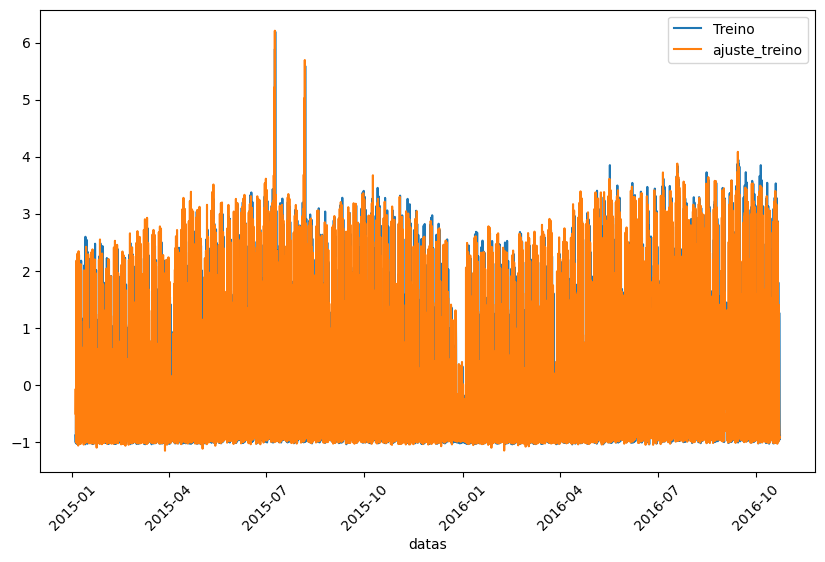

In [40]:
# Prevendo os dados de treino.
y_ajustado = recorrente.predict(X_treino_novo)

# Gerando o gráfico.
plt.figure(figsize=(10,6))
sns.lineplot(x='datas', y=y_treino[:,0], data=df[0:tamanho_treino], label='Treino')
sns.lineplot(x='datas', y=y_ajustado[:,0], data=df[0:15662], label='ajuste_treino')
plt.xticks(rotation=45)
plt.show()

Ao analisar o gráfico, a rede neural conseguiu fazer previsões bastante razoáveis, sugerindo que o modelo foi capaz de capturar os padrões nos dados e produzir saídas que se alinham de forma satisfatória com os resultados reais.

55/55 [==============================] - 0s 7ms/step


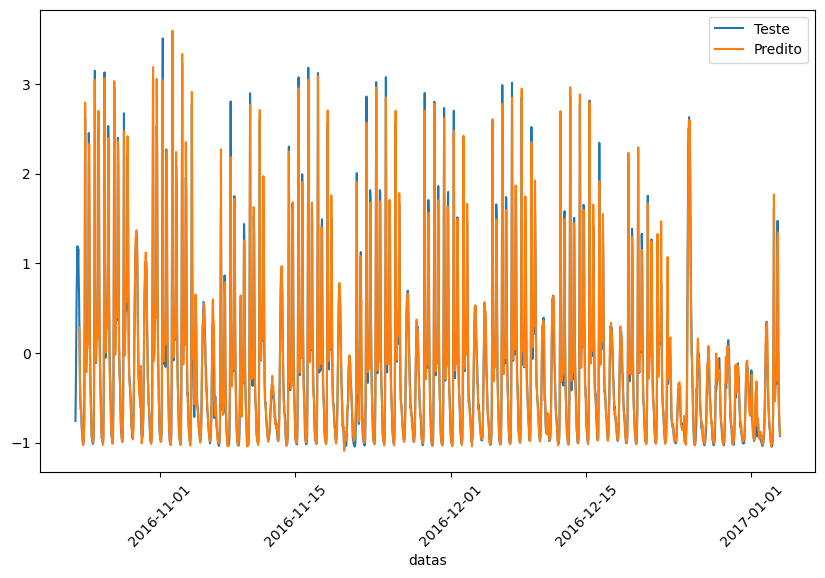

In [39]:
# Prevendo os dados de teste.
y_predito = recorrente.predict(X_teste_novo)

# Gerando o gráfico.
plt.figure(figsize=(10,6))
sns.lineplot(x='datas', y=y_teste[:,0], data=df[tamanho_treino:len(df)], label='Teste')
sns.lineplot(x='datas', y=y_predito[:,0], data=df[tamanho_treino+10:len(df)], label='Predito')
plt.xticks(rotation=45)
plt.show()

Quanto os dados de teste, o modelo também previu os dados relativamente bem.

### Criando a rede neural recorrente - GRU

A GRU tem uma estrutura mais simples com número menor de camadas de redes neurais dentro dela.
Isso faz com que o treinamento da GRU seja mais rápido, pois ela tem menos parâmetros para treinar, só que, da literatura, sabemos que as LSTM’s conseguem lembrar de sequências maiores. Por isso, as GRU normalmente são utilizadas para sequências menores, quando nós temos menos dados, e as LSTM’s para sequências maiores, quando temos mais dados.

In [43]:
# Criando a rede neural recorrente - GRU.
recorrente_g = Sequential(
    [keras.layers.GRU(128, input_shape=(X_treino_novo.shape[1], X_treino_novo.shape[2])),
     keras.layers.Dense(1)
    ])

# Compilando a rede neural recorrente - GRU.
recorrente_g.compile(loss='mean_squared_error', optimizer='RMSprop')

# Treinando a rede neural recorrente - GRU.
resultado2 = recorrente_g.fit(X_treino_novo, y_treino_novo, validation_data=(X_teste_novo, y_teste_novo), epochs=100)

55/55 [==============================] - 1s 4ms/step


<Axes: xlabel='datas'>

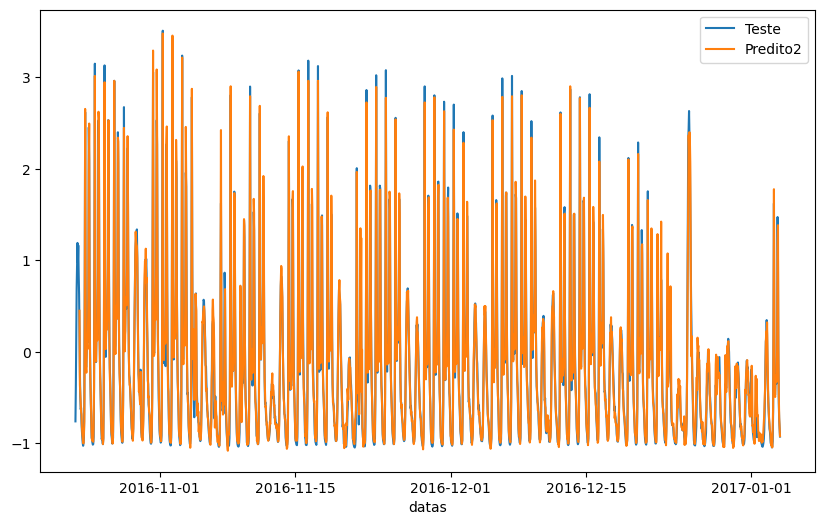

In [47]:
# Prevendo os dados de teste.
y_predito2 = recorrente_g.predict(X_teste_novo)

# Gerando o gráfico.
plt.figure(figsize=(10,6))
sns.lineplot(x='datas', y=y_teste[:,0], data=df[tamanho_treino:len(df)], label='Teste')
sns.lineplot(x='datas', y=y_predito2[:,0], data=df[tamanho_treino+10:len(df)], label='Predito2')

O modelo GRU gerou previsões que se assemelham às do modelo anterior (LSTM). Isso pode indicar que ambos os modelos aprenderam padrões semelhantes nos dados ou que estão aplicando estratégias de previsão semelhantes.

## Comparando os resultados

In [44]:
recorrente.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
recorrente_g.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 50433 (197.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


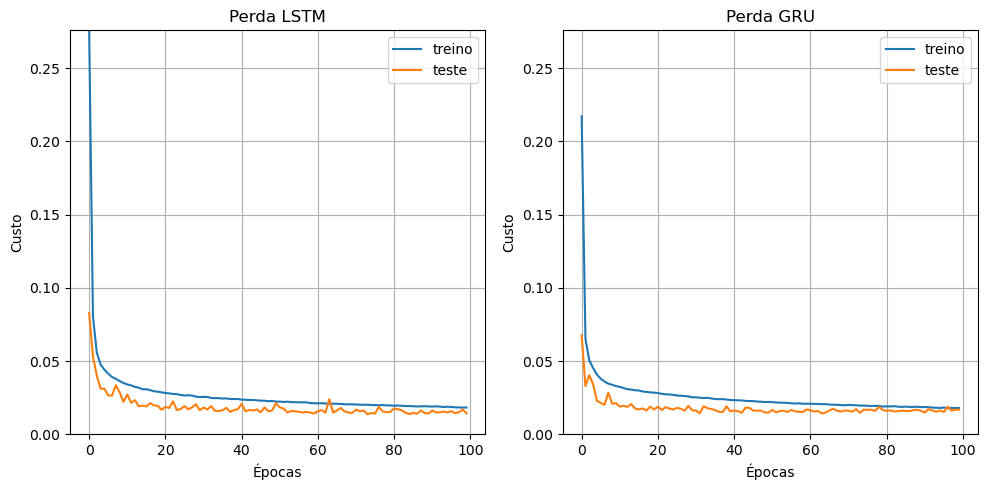

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

axs[0].plot(resultado.history['loss'])
axs[0].plot(resultado.history['val_loss'])
axs[0].set_title('Perda LSTM')
axs[0].legend(['treino', 'teste'])
axs[0].set_xlabel('Épocas')
axs[0].set_ylabel('Custo')
axs[0].grid(True)
axs[0].set_ylim([0, max(max(resultado.history['loss']), max(resultado.history['val_loss']))])

axs[1].plot(resultado2.history['loss'], label='Treino2')
axs[1].plot(resultado2.history['val_loss'], label='Teste2')
axs[1].set_title('Perda GRU')
axs[1].legend(['treino', 'teste'])
axs[1].set_xlabel('Épocas')
axs[1].set_ylabel('Custo')
axs[1].grid(True)
axs[1].set_ylim([0, max(max(resultado.history['loss']), max(resultado.history['val_loss']))])

plt.tight_layout()
plt.show()

### Conclusão

Ao analisar os dois gráficos, pode-se notar que tanto nos conjuntos de treinamento quanto nos de teste, a performance foi satisfatória, indicando que o modelo foi capaz de capturar efetivamente os padrões nos dados. 
Neste caso, optar pela GRU (Gated Recurrent Unit) pode ser uma escolha vantajosa, já que é uma alternativa às LSTMs que oferece resultados similares em termos de desempenho, mas com menos parâmetros para treinar e uma execução um pouco mais rápida. Considerando que ambas estão oferecendo resultados comparáveis, a GRU pode ser uma opção mais eficiente em termos de recursos computacionais.